In [1]:
import numpy as np
from scipy.io import loadmat
# from sklearn.neighbors import KDTree
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

## Belief update for a single cell
<div>
<img src="logodds.png" width="500" align="left"/>
</div>

## Belief update for map
<div>
<img src="mapping.png" width="500" align="left"/>
</div>

## Inverse sensor model
<div>
<img src="inverse_sensor.png" width="500" align="left"/>
</div>

In [2]:
#! usr/bin/env python

#
# Occupancy Grid Mapping Class
#
# Author: Fangtong Liu
# Date: 04/18/2020
#

# This function is used to convert Cartesian to Polar
def cart2pol(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    z = np.hstack((r.reshape(-1, 1), theta.reshape(-1, 1)))
    return z


# This function is used to wrap angles in radians to the interval [-pi, pi]
# pi maps to pi and -pi maps to -pi
def wrapToPI(phase):
    x_wrap = np.remainder(phase, 2 * np.pi)
    idx = np.argwhere(np.abs(x_wrap) > np.pi)
    while len(idx):
        x_wrap[idx] -= 2 * np.pi * np.sign(x_wrap[idx])
        idx = np.argwhere(np.abs(x_wrap) > np.pi)
    return x_wrap


# Occupancy Grid Mapping Class
class occupanvy_grid_map:

    def __init__(self):
        # map dimensions
        self.range_x = [-15, 20]
        self.range_y = [-25, 10]
        # senesor parameters
        self.z_max = 30  # max range in meters
        self.n_beams = 133  # number of beams
        # grid map parameters
        self.grid_size = 0.27 # 0.135 / 2
        self.alpha = 2 * self.grid_size  # 2 * grid size
        self.beta = 2 * np.pi / self.n_beams  # 2 * pi / n_beams
        self.nn = 16  # number of nearest neighbor search
        # log odds
        self.l_occ = 3
        self.l_free = -3
        self.l_prior = 0
        self.map = {}  # map
        self.pose = {}  # pose data
        self.scan = []  # laser scan data
        self.m_i = {}  # cell i

    def occupancy_grid_map_construct(self, pose, scan):
        # class constructor
        # construct map points, i.e., grid centroids
        x = np.arange(self.range_x[0], self.range_x[1]+self.grid_size, self.grid_size)
        y = np.arange(self.range_y[0], self.range_y[1]+self.grid_size, self.grid_size)
        X, Y = np.meshgrid(x, y)
        t = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        # a simple KDTree data structure for map coordinates
        self.map['occMap'] = KDTree(t)
        self.map['prob'] = 0.5 * np.ones([t.shape[0], 1])
        self.map['logodd'] = self.l_prior * np.ones([t.shape[0], 1])
        self.map['size'] = t.shape[0]
        # set robot pose and laser scan data
        self.pose['x'] = pose['x'][0][0]
        self.pose['y'] = pose['y'][0][0]
        self.pose['h'] = pose['h'][0][0]
        self.pose['mdl'] = KDTree(np.hstack((self.pose['x'], self.pose['y'])))
        self.scan = scan

    def is_in_perceptual_field(self, m, p):
        # check if the map cell m is within the perception field of the
        # robot located at pose p
        d = m - p[0:2].reshape(-1)
        self.m_i['range'] = np.sqrt(np.sum(np.power(d, 2)))
        self.m_i['phi'] = wrapToPI(np.arctan2(d[1], d[0]) - p[2])
        # check if the range is within the feasible interval
        if (self.m_i['range'] > 0) and (self.m_i['range'] < self.z_max):
            # here sensor covers -pi to pi
            if (self.m_i['phi'] > -np.pi) and (self.m_i['phi'] < np.pi):
                return True
        return False

    def inverse_sensor_model(self, z):
        # set the default value to prior log odd
        l_inv = self.l_prior
        bearing_diff = []
        # find the nearest beam
        bearing_diff = np.abs(wrapToPI(z[:, 1] - self.m_i['phi']))
        k = np.nanargmin(bearing_diff)
        bearing_min = bearing_diff[k]
        if (self.m_i['range'] > min(self.z_max, z[k, 0] + self.alpha / 2)) or (bearing_min > self.beta / 2):
            l_inv = self.l_prior
        elif (z[k, 0] < self.z_max) and (np.abs(self.m_i['range'] - z[k, 0]) < self.alpha / 2):
            l_inv = self.l_occ
        elif (self.m_i['range'] < z[k, 0]) and (z[k, 0] < self.z_max):
            l_inv = self.l_free
        return l_inv

    def build_ogm(self):
        # build occupancy grid map using the binary Bayes filter.
        # We first loop over all map cells, then for each cell, we find
        # N nearest neighbor poses to build the map. Note that this is
        # more efficient than looping over all poses and all map cells
        # for each pose which should be the case in online (incremental)
        # data processing.
        for i in tqdm(range(self.map['size'])):
            m = self.map['occMap'].data[i, :]
            neighbour, idxs = self.pose['mdl'].query(m, self.nn)
            if len(idxs):
                for k in idxs:
                    # pose k
                    pose_k = np.array([self.pose['x'][k], self.pose['y'][k], self.pose['h'][k]])
                    if self.is_in_perceptual_field(m, pose_k):
                        # laser scan at kth state; convert from cartesian to
                        # polar coordinates
                        z = cart2pol(self.scan[k][0][0, :], self.scan[k][0][1, :])
                        # update the cell i belief using log odds formula
                        self.map['logodd'][i] = self.inverse_sensor_model(z) + self.map['logodd'][i] - self.l_prior

    def plot(self):
        print('Plotting ogm map')
        # plot ogm using conventional black-gray-white cells
        fig, ax = plt.subplots()
        h = self.grid_size / 2
        rect_collection = []  # create a list for all map cells
        for i in range(self.map['size']):
            m = self.map['occMap'].data[i, :]
            x = m[0] - h
            y = m[1] - h
            probability = 1 - 1 / (1 + np.exp(self.map['logodd'][i]))
            color = (1 - probability)*np.array([1, 1, 1])  # map cell colors
            rect = Rectangle((x, y), self.grid_size, self.grid_size, facecolor=color, edgecolor=color)  # map cells
            ax.add_patch(rect)
        ax.autoscale_view()
        ax.set_xlim(self.range_x)
        ax.set_ylim(self.range_y)
        plt.axis('equal')
        fig.savefig('ogm_intel.png')
        plt.show()

In [1]:
#! usr/bin/env python

#
# occupancy grid mapping example
# Author: Fangtong Liu
# Date: 04/18/2020
#

dataLoad = loadmat('sample_Intel_dataset.mat')
robotPose = dataLoad['robotPose']
laserScan = dataLoad['laserScan']
globalLaserScan = dataLoad['globalLaserScan']

# color
green = np.array([0.2980, 0.6, 0])
crimson = np.array([220, 20, 60]) / 255
darkgrey = [0.35, 0.35, 0.35]

print('Plotting dataset')
fig = plt.figure()
ax = fig.gca()
ax.plot(robotPose['x'][0][0], robotPose['y'][0][0], linewidth=2)
for i in range(len(laserScan)):
    ax.plot(globalLaserScan[i][0][0, :], globalLaserScan[i][0][1, :], '.', color=darkgrey, alpha=0.9, markersize=4)
ax.plot(robotPose['x'][0][0][0], robotPose['y'][0][0][0], 's', color=green, alpha=0.8, markersize=14)
ax.plot(robotPose['x'][0][0][-1], robotPose['y'][0][0][-1], 'o', color=crimson, alpha=0.8, markersize=14)
plt.axis('equal')
plt.tight_layout()
fig.savefig('ptcloud_intel.png')
plt.show()

NameError: name 'loadmat' is not defined

100%|██████████| 17161/17161 [00:09<00:00, 1819.48it/s]


Plotting ogm map


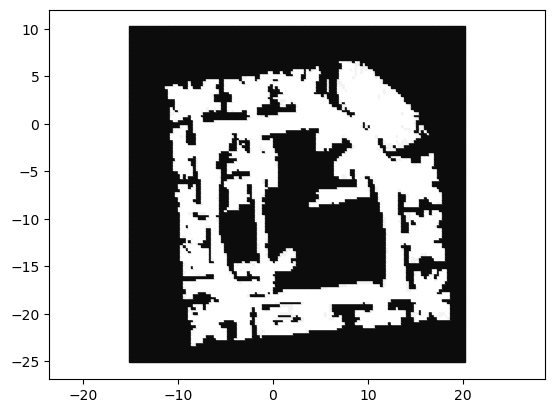

In [23]:
ogm = occupanvy_grid_map()
ogm.occupancy_grid_map_construct(robotPose, laserScan)
ogm.build_ogm()

ogm.plot()